# LATE vs ATE: What IV Actually Estimates

**Chapter 9, Section 2**

This notebook explains why IV estimates the Local Average Treatment Effect (LATE) on compliers, not the Average Treatment Effect (ATE) on the full population.

## Table of Contents
1. [Intuition](#intuition) - Effect on compliers only
2. [Formal Treatment](#formal) - LATE identification
3. [Numeric Demonstration](#numeric) - ITT vs LATE vs naive OLS
4. [Implementation](#implementation) - Computing LATE
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### Why IV Doesn't Give the ATE

Recall the four principal strata:

| Stratum | If Z=1 | If Z=0 | Effect of Z on D? |
|---------|--------|--------|--------------|
| Compliers | D=1 | D=0 | **Yes** |
| Always-Takers | D=1 | D=1 | No |
| Never-Takers | D=0 | D=0 | No |
| Defiers | D=0 | D=1 | Yes (wrong direction) |

**Key insight**: For always-takers and never-takers, the instrument Z doesn't change treatment D. So comparing outcomes by Z can't tell us about treatment effects for these groups.

**IV identifies the treatment effect only for those whose treatment status is changed by the instrument** - the compliers.

---

### The Three Estimands

| Estimand | Definition | Who it applies to |
|----------|------------|-------------------|
| **ATE** | $E[Y(1) - Y(0)]$ | Entire population |
| **ITT** | $E[Y | Z=1] - E[Y | Z=0]$ | Entire population, effect of *assignment* |
| **LATE** | $E[Y(1) - Y(0) | \text{Complier}]$ | Compliers only |

**Relationships**:
- ITT = LATE $\times$ P(Complier) (under monotonicity + exclusion)
- LATE = ITT / P(Complier) = ITT / First Stage
- LATE = ATE only if treatment effects are homogeneous

---

In [2]:
# Load push notification data
push = load_facure_data("app_engagement_push.csv")

print(f"Data: {len(push):,} users")
print(f"\nVariables:")
print(f"  Z (push_assigned): Random assignment")
print(f"  D (push_delivered): Treatment received")
print(f"  Y (in_app_purchase): Outcome")

# Quick summary
print(f"\nAssignment rate: {push['push_assigned'].mean():.1%}")
print(f"Overall delivery rate: {push['push_delivered'].mean():.1%}")

Data: 10,000 users

Variables:
  Z (push_assigned): Random assignment
  D (push_delivered): Treatment received
  Y (in_app_purchase): Outcome

Assignment rate: 49.4%
Overall delivery rate: 35.5%


---

## Formal Treatment

### LATE Identification Theorem

Under the following assumptions:

1. **Independence**: $(Y(1), Y(0), D(1), D(0)) \perp Z$
2. **Exclusion Restriction**: $Y(z, d) = Y(d)$ for all $z$
3. **First Stage**: $P(D(1) = 1) \neq P(D(0) = 1)$
4. **Monotonicity**: $D_i(1) \geq D_i(0)$ for all $i$ (no defiers)

The IV (Wald) estimator identifies:

$$\text{LATE} = E[Y(1) - Y(0) | D(1) > D(0)] = \frac{E[Y|Z=1] - E[Y|Z=0]}{E[D|Z=1] - E[D|Z=0]}$$

This is the **average treatment effect on compliers**.

### Proof Sketch

**Step 1**: Express the ITT numerator.

Using the exclusion restriction, we can write:
$$E[Y|Z=1] = E[Y(D(1))|Z=1] = E[Y_0 + D(1) \cdot (Y_1 - Y_0)]$$

By independence:
$$E[Y|Z=1] = E[Y_0] + E[D(1) \cdot (Y_1 - Y_0)]$$

Similarly:
$$E[Y|Z=0] = E[Y_0] + E[D(0) \cdot (Y_1 - Y_0)]$$

**Step 2**: Take the difference.

$$E[Y|Z=1] - E[Y|Z=0] = E[(D(1) - D(0)) \cdot (Y_1 - Y_0)]$$

**Step 3**: Apply monotonicity.

Since $D(1) - D(0) \in \{0, 1\}$ (no defiers), we can write:

$$E[(D(1) - D(0)) \cdot (Y_1 - Y_0)] = E[Y_1 - Y_0 | D(1) > D(0)] \cdot P(D(1) > D(0))$$

**Step 4**: The first stage gives $P(D(1) > D(0)) = E[D|Z=1] - E[D|Z=0]$.

**Conclusion**: Dividing ITT by first stage yields LATE on compliers. $\square$

In [3]:
# Calculate each component manually

# Split by assignment
assigned = push[push['push_assigned'] == 1]
not_assigned = push[push['push_assigned'] == 0]

# ITT (Reduced Form): E[Y|Z=1] - E[Y|Z=0]
E_Y_Z1 = assigned['in_app_purchase'].mean()
E_Y_Z0 = not_assigned['in_app_purchase'].mean()
ITT = E_Y_Z1 - E_Y_Z0

# First Stage: E[D|Z=1] - E[D|Z=0]
E_D_Z1 = assigned['push_delivered'].mean()
E_D_Z0 = not_assigned['push_delivered'].mean()
first_stage = E_D_Z1 - E_D_Z0

# LATE = ITT / First Stage
LATE = ITT / first_stage

print("ESTIMAND DECOMPOSITION")
print("=" * 55)
print(f"\nE[Y | Z=1] = ${E_Y_Z1:.2f}")
print(f"E[Y | Z=0] = ${E_Y_Z0:.2f}")
print(f"ITT (Reduced Form) = ${ITT:.2f}")
print(f"\nE[D | Z=1] = {E_D_Z1:.3f}")
print(f"E[D | Z=0] = {E_D_Z0:.3f}")
print(f"First Stage = {first_stage:.3f} (proportion of compliers)")
print(f"\nLATE = ITT / First Stage = ${ITT:.2f} / {first_stage:.3f} = ${LATE:.2f}")

ESTIMAND DECOMPOSITION

E[Y | Z=1] = $71.66
E[Y | Z=0] = $69.29
ITT (Reduced Form) = $2.36

E[D | Z=1] = 0.718
E[D | Z=0] = 0.000
First Stage = 0.718 (proportion of compliers)

LATE = ITT / First Stage = $2.36 / 0.718 = $3.29


---

## Numeric Demonstration

### Comparing Three Approaches

In [4]:
# 1. Naive OLS: Compare treated vs untreated (BIASED)
naive_model = smf.ols('in_app_purchase ~ push_delivered', data=push).fit()
naive_effect = naive_model.params['push_delivered']
naive_se = naive_model.bse['push_delivered']

# 2. ITT: Compare by assignment (unbiased for ITT, but not treatment effect)
itt_model = smf.ols('in_app_purchase ~ push_assigned', data=push).fit()
itt_effect = itt_model.params['push_assigned']
itt_se = itt_model.bse['push_assigned']

# 3. LATE via Wald: ITT / First Stage
first_stage_model = smf.ols('push_delivered ~ push_assigned', data=push).fit()
first_stage_coef = first_stage_model.params['push_assigned']
late_effect = itt_effect / first_stage_coef

# Summary
print("COMPARISON OF ESTIMATORS")
print("=" * 55)
print(f"\n{'Method':<25} {'Estimate':>10} {'SE':>10} {'Interpretation'}")
print("-" * 70)
print(f"{'Naive OLS':<25} ${naive_effect:>9.2f} {naive_se:>10.2f}   BIASED (selection)")
print(f"{'ITT (assignment)':<25} ${itt_effect:>9.2f} {itt_se:>10.2f}   Effect of assignment")
print(f"{'LATE (Wald)':<25} ${late_effect:>9.2f} {'--':>10}   Effect on compliers")
print(f"\nBias in Naive: ${naive_effect - late_effect:.2f} (overstated due to selection)")

COMPARISON OF ESTIMATORS

Method                      Estimate         SE Interpretation
----------------------------------------------------------------------
Naive OLS                 $    13.93       0.53   BIASED (selection)
ITT (assignment)          $     2.36       0.52   Effect of assignment
LATE (Wald)               $     3.29         --   Effect on compliers

Bias in Naive: $10.64 (overstated due to selection)


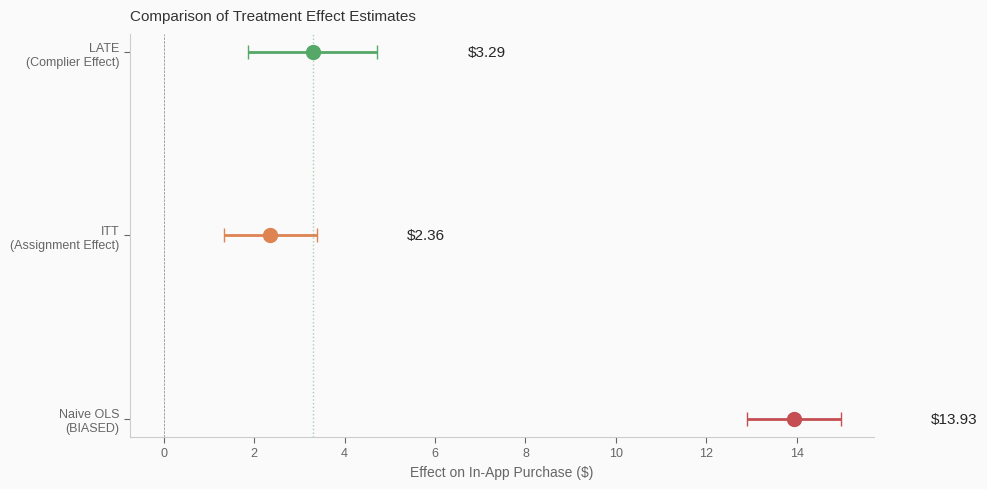


Naive OLS is $11 higher than true LATE!
This is because rich customers (new phones) both receive push AND spend more.


In [5]:
# Visualize the three estimates
fig, ax = create_tufte_figure(figsize=(10, 5))

estimates = {
    'Naive OLS\n(BIASED)': (naive_effect, naive_se, COLORS['red']),
    'ITT\n(Assignment Effect)': (itt_effect, itt_se, COLORS['orange']),
    'LATE\n(Complier Effect)': (late_effect, itt_se/first_stage_coef, COLORS['green']),  # Delta method SE approximation
}

y_pos = list(range(len(estimates)))
for i, (label, (est, se, color)) in enumerate(estimates.items()):
    ax.errorbar(est, i, xerr=1.96*se, fmt='o', color=color, 
                capsize=5, markersize=10, linewidth=2)
    ax.text(est + 1.96*se + 2, i, f'${est:.2f}', va='center', fontsize=11)

ax.set_yticks(y_pos)
ax.set_yticklabels(list(estimates.keys()))
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=LATE, color=COLORS['green'], linestyle=':', linewidth=1, alpha=0.5)

set_tufte_title(ax, "Comparison of Treatment Effect Estimates")
set_tufte_labels(ax, "Effect on In-App Purchase ($)", "")

plt.tight_layout()
plt.show()

print(f"\nNaive OLS is ${naive_effect - LATE:.0f} higher than true LATE!")
print(f"This is because rich customers (new phones) both receive push AND spend more.")

### When LATE = ATE?

LATE equals ATE when:

1. **100% compliance**: Everyone is a complier ($\pi_C = 1$)
   - Then LATE = ATE trivially

2. **Homogeneous treatment effects**: $Y_i(1) - Y_i(0) = \tau$ for all $i$
   - Then $E[\tau | \text{Complier}] = E[\tau] = \tau$

3. **Effect independence from stratum**: Treatment effect doesn't vary by compliance type
   - $E[Y(1)-Y(0)|\text{Complier}] = E[Y(1)-Y(0)|\text{Never-taker}] = ...$

In practice, these conditions often fail:
- Compliers may have different responses than never-takers
- Selection into compliance may correlate with treatment response

In [6]:
# External validity concern: Who are the compliers?
print("EXTERNAL VALIDITY: WHO ARE THE COMPLIERS?")
print("=" * 55)

# We can characterize compliers by looking at who actually received when assigned
# vs who didn't receive when not assigned

# Among assigned: compliers + always-takers received
# Among not assigned: only always-takers received

print("\nIn the push notification example:")
print(f"  - Compliers: ~{first_stage_coef:.1%} of population")
print(f"  - These are users with NEWER phones (can receive push)")
print(f"  - Newer phones correlate with higher income")
print(f"\nConsequence:")
print(f"  - LATE applies to the richer segment")
print(f"  - Cannot generalize to never-takers (poorer users)")
print(f"  - Treatment effect might be different for them")

EXTERNAL VALIDITY: WHO ARE THE COMPLIERS?

In the push notification example:
  - Compliers: ~71.8% of population
  - These are users with NEWER phones (can receive push)
  - Newer phones correlate with higher income

Consequence:
  - LATE applies to the richer segment
  - Cannot generalize to never-takers (poorer users)
  - Treatment effect might be different for them


---

## Implementation

### Computing LATE with Wald Estimator

In [7]:
def wald_estimator(df, outcome_col, treatment_col, instrument_col):
    """
    Compute the Wald (LATE) estimator.
    
    LATE = (E[Y|Z=1] - E[Y|Z=0]) / (E[D|Z=1] - E[D|Z=0])
    
    Parameters
    ----------
    df : pd.DataFrame
    outcome_col : str
        Outcome variable Y.
    treatment_col : str
        Treatment variable D.
    instrument_col : str
        Instrument variable Z.
        
    Returns
    -------
    dict
        LATE estimate and components.
    """
    Y = df[outcome_col]
    D = df[treatment_col]
    Z = df[instrument_col]
    
    # ITT (reduced form)
    E_Y_Z1 = Y[Z == 1].mean()
    E_Y_Z0 = Y[Z == 0].mean()
    ITT = E_Y_Z1 - E_Y_Z0
    
    # First stage
    E_D_Z1 = D[Z == 1].mean()
    E_D_Z0 = D[Z == 0].mean()
    first_stage = E_D_Z1 - E_D_Z0
    
    # Check for weak instrument
    if abs(first_stage) < 0.01:
        raise ValueError(f"Weak instrument: first stage = {first_stage:.4f}")
    
    # LATE
    LATE = ITT / first_stage
    
    # SE via delta method (approximate)
    n = len(df)
    se_ITT = np.sqrt(Y[Z==1].var()/sum(Z==1) + Y[Z==0].var()/sum(Z==0))
    se_LATE = se_ITT / first_stage  # Approximate, ignores first-stage variance
    
    return {
        'LATE': LATE,
        'ITT': ITT,
        'first_stage': first_stage,
        'se_LATE_approx': se_LATE,
        'n': n,
        'n_Z1': sum(Z == 1),
        'n_Z0': sum(Z == 0),
    }

# Test
result = wald_estimator(push, 'in_app_purchase', 'push_delivered', 'push_assigned')
print("Wald Estimator Results:")
for k, v in result.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

Wald Estimator Results:
  LATE: 3.2938
  ITT: 2.3636
  first_stage: 0.7176
  se_LATE_approx: 0.7260
  n: 10000
  n_Z1: 4943
  n_Z0: 5057


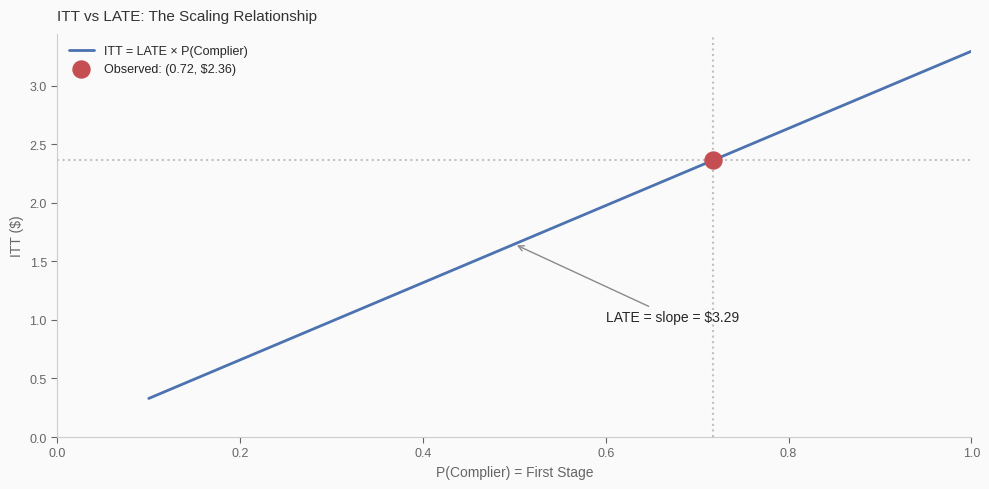


As compliance decreases, ITT shrinks toward zero.
But LATE (effect per complier) remains constant at $3.29.


In [8]:
# Relationship between ITT and LATE
fig, ax = create_tufte_figure(figsize=(10, 5))

# Show ITT = LATE * first_stage
complier_rates = np.linspace(0.1, 1.0, 100)
ITT_line = LATE * complier_rates

ax.plot(complier_rates, ITT_line, color=COLORS['blue'], linewidth=2,
        label='ITT = LATE × P(Complier)')

# Mark actual values
ax.scatter([first_stage_coef], [ITT], color=COLORS['red'], s=150, zorder=5,
           label=f'Observed: ({first_stage_coef:.2f}, ${ITT:.2f})')
ax.axhline(y=ITT, color=COLORS['gray'], linestyle=':', alpha=0.5)
ax.axvline(x=first_stage_coef, color=COLORS['gray'], linestyle=':', alpha=0.5)

# Annotations
ax.annotate(f'LATE = slope = ${LATE:.2f}', 
            xy=(0.5, LATE * 0.5), xytext=(0.6, LATE * 0.3),
            arrowprops=dict(arrowstyle='->', color=COLORS['gray']),
            fontsize=10)

ax.set_xlim(0, 1)
ax.set_ylim(0, None)
set_tufte_title(ax, "ITT vs LATE: The Scaling Relationship")
set_tufte_labels(ax, "P(Complier) = First Stage", "ITT ($)")
ax.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

print(f"\nAs compliance decreases, ITT shrinks toward zero.")
print(f"But LATE (effect per complier) remains constant at ${LATE:.2f}.")

---

## Interview Appendix

### Practice Questions

**Q1: What is the difference between ITT and LATE?**

<details>
<summary>Solution</summary>

| Aspect | ITT | LATE |
|--------|-----|------|
| **Definition** | $E[Y|Z=1] - E[Y|Z=0]$ | $E[Y(1)-Y(0)|\text{Complier}]$ |
| **Estimand** | Effect of *assignment* | Effect of *treatment* |
| **Population** | Everyone | Compliers only |
| **Requires** | Random assignment | + Exclusion + Monotonicity |
| **Relationship** | ITT = LATE $\times$ P(Complier) | LATE = ITT / First Stage |

**ITT** answers: "What's the effect of being assigned to treatment?"
**LATE** answers: "What's the effect of treatment on those who comply?"

ITT is always identified (just needs random Z). LATE requires additional assumptions.

</details>

**Q2: When does LATE equal ATE?**

<details>
<summary>Solution</summary>

LATE = ATE when treatment effects are **homogeneous** (constant across all units) OR when the treatment effect is **independent of compliance type**.

Formally:
$$\text{LATE} = E[Y(1)-Y(0)|\text{Complier}] = E[Y(1)-Y(0)] = \text{ATE}$$

if either:
1. $Y_i(1) - Y_i(0) = \tau$ for all $i$ (constant effect)
2. $(Y(1) - Y(0)) \perp \text{Compliance Type}$ (effect independent of stratum)

In practice, this often fails because:
- Compliers may respond differently than non-compliers
- Selection into compliance correlates with treatment responsiveness
- Never-takers might have larger/smaller effects if they could be treated

</details>

**Q3: Why is the Wald estimator LATE and not ATE?**

<details>
<summary>Solution</summary>

The Wald estimator:
$$\hat{\tau}_{\text{Wald}} = \frac{E[Y|Z=1] - E[Y|Z=0]}{E[D|Z=1] - E[D|Z=0]}$$

**Why it's LATE**:

1. The numerator (ITT) captures the effect of Z on Y
2. For always-takers and never-takers, Z doesn't change D, so Z doesn't affect their Y (under exclusion)
3. Only compliers have D change when Z changes
4. Therefore, the ITT is driven entirely by compliers: ITT = $\tau_C \times \pi_C$
5. Dividing by the first stage ($\pi_C$) recovers $\tau_C$ = LATE

**Intuition**: We're comparing outcomes based on an instrument that only "works" (changes treatment) for compliers. So we can only learn about compliers.

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 9.

[^2]: Imbens, G. W., & Angrist, J. D. (1994). Identification and estimation of local average treatment effects. *Econometrica*, 62(2), 467-475.

[^3]: Cross-reference: IV estimation in `08_instrumental_variables/02_two_stage_least_squares.ipynb`